# Elo Merchant Category Recommendation

---
@2020.01.28
@lazyerIJ<br/>
<br/>
**About EDA**<br/>
https://github.com/LazyerIJ/Kaggle_Study/blob/master/Competitions/Elo_Merchant_Category_Recommendation/src/IJ/src/EDA_data_distribution.ipynb
https://github.com/LazyerIJ/Kaggle_Study/blob/master/Competitions/Elo_Merchant_Category_Recommendation/src/IJ/src/EDA_data_with_target.ipynb
https://github.com/LazyerIJ/Kaggle_Study/blob/master/Competitions/Elo_Merchant_Category_Recommendation/src/IJ/src/EDA_month_lag_rate.ipynb
https://github.com/LazyerIJ/Kaggle_Study/blob/master/Competitions/Elo_Merchant_Category_Recommendation/src/IJ/src/EDA_new_and_old.ipynb

In [1]:
#packages
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
#settings
warnings.filterwarnings('ignore')
np.random.seed(2019)
pd.set_option('max_columns', None)

In [2]:
#logger
def get_logger():
    FORMAT = '[%(levelname)s]%(asctime)s:%(name)s:%(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)
    return logger
logger = get_logger()

In [3]:
## Pandas@reduce dataframe memory
def reduce_mem_usage(props, fillna=False, fillval=None):
    print('[*]Start')
    start_mem_usg = round(props.memory_usage().sum() / 1024**2, 2)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # Print current column type
            print("Column: ", col)
            before_type = props[col].dtype
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                if not fillna:
                    print('>>skip {} cause of NA value'.format(col))
                    continue
                NAlist.append(col)
                props[col].fillna(fillval,inplace=True)  
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < pow(2, 8)-1:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < pow(2, 16)-1:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < pow(2, 32)-1:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            # Print new column type
            after_type = props[col].dtype
            print(">>dtype : {} -> {}".format(before_type, after_type))
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = round(props.memory_usage().sum() / 1024**2, 2) 
    percent = round(100*mem_usg/start_mem_usg, 2)
    print("Memory usage : {}MB -> {}MB ({}% decrease)".format(start_mem_usg, mem_usg, percent))
    return props, NAlist

# 1. Check files

In [4]:
input_dir = os.path.join('..', 'input')
file_csv = [file for file in os.listdir(input_dir)\
            if file.endswith('.csv')]
print(file_csv)

['historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'train.csv', 'test.csv']


- historical_transactions.csv
- merchants.csv
- ner_merchant_transactions.csv
- sample_submission.csv
- train.csv
- test.csv

In [5]:
#load data
logger.info('Start read data')
fillna = False
fillval = -999
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))
historical_trans_df = pd.read_csv(os.path.join(input_dir, 'historical_transactions.csv'))
new_merchant_trans_df = pd.read_csv(os.path.join(input_dir, 'new_merchant_transactions.csv'))
train_df, _ = reduce_mem_usage(train_df, fillna=fillna, fillval=fillval)
test_df, _ = reduce_mem_usage(test_df, fillna=fillna, fillval=fillval)
historical_trans_df, _ = reduce_mem_usage(historical_trans_df, fillna=fillna, fillval=fillval)
new_merchant_trans_df, _ = reduce_mem_usage(new_merchant_trans_df, fillna=False, fillval=-999)
print('done')

[INFO]2020-01-30 18:31:48,725:main:Start read data


[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
Column:  target
>>dtype : float64 -> float32
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 9.24MB -> 4.43MB (47.94% decrease)
[*]Start
Column:  feature_1
>>dtype : int64 -> uint8
Column:  feature_2
>>dtype : int64 -> uint8
Column:  feature_3
>>dtype : int64 -> uint8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 4.72MB -> 2.24MB (47.46% decrease)
[*]Start
Column:  city_id
>>dtype : int64 -> int16
Column:  installments
>>dtype : int64 -> int16
Column:  merchant_category_id
>>dtype : int64 -> int16
Column:  month_lag
>>dtype : int64 -> int8
Column:  purchase_amount
>>dtype : float64 -> float32
Column:  category_2
>>skip category_2 cause of NA value
Column:  state_id
>>dtype : int64 -> int8
Column:  subsector_id
>>dtype : int64 -> int8
___MEMORY USAGE AFTER COMPLETION:___
Memory usage : 3109.54MB -> 1915.7MB (61.61% decrease)
[*]Start
Colu

# 2. Pre-processing

## 1. Fill nan value

In [6]:
historical_trans_df.isnull().sum() + new_merchant_trans_df.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               234081
merchant_category_id          0
merchant_id              164697
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2764609
state_id                      0
subsector_id                  0
dtype: int64

In [7]:
##Check nan column unique vals
print('hist - category_2 : {}'.format(historical_trans_df.category_2.unique()))
print('new_hist - category_2 : {}'.format(new_merchant_trans_df.category_2.unique()))

hist - category_2 : [ 1. nan  3.  5.  2.  4.]
new_hist - category_2 : [ 1. nan  3.  2.  4.  5.]


In [8]:
##Check nan column unique vals
print('hist - category_3 : {}'.format(historical_trans_df.category_3.unique()))
print('new_hist - category_3 : {}'.format(new_merchant_trans_df.category_3.unique()))

hist - category_3 : ['A' 'B' 'C' nan]
new_hist - category_3 : ['B' nan 'C' 'A']


In [9]:
#process NAs
logger.info('Start processing NAs')
#process NA2 for transactions
for df in [historical_trans_df, new_merchant_trans_df]:
    df['category_2'].fillna(0.0,inplace=True)
    df['category_3'].fillna('None',inplace=True)
    df['merchant_id'].fillna('None',inplace=True)
print('done')

[INFO]2020-01-30 18:32:51,767:main:Start processing NAs


done


## 2. Feature engineering

In [10]:
#define function for aggregation
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

### 1) Get holiday information in Brazil

- use workalendar library
- use feature with purchase_amount feature

In [11]:
import workalendar
from workalendar.america import Brazil
cal = Brazil()
holidays_all= []
for yr in [2017,2018]:
    hols=cal.holidays(yr)
    for i in range(len(cal.holidays(yr))):
        holidays_all.append(hols[i][0])

### 2) Data type processing and add columns

- fix datetype features
- max categorical features
- get basement date features
- add holidays features

In [12]:
logger.info('process historical and new merchant datasets')
for df in [historical_trans_df, new_merchant_trans_df]:
    #fix datetype features
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    #map categorical features
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':1, 'B':2, 'C':3, 'None':0}) 
    #get basement date features
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    #holidays = weekend or holiday
    df['holidays'] = df['purchase_date'].apply(lambda x : 1 if x in holidays_all else 0)
    df['holidays'] = df['holidays'] + df['weekend']
    df['holidays'] = (df.holidays>=1).astype(int)
print('done')

[INFO]2020-01-30 18:32:53,286:main:process historical and new merchant datasets


done


### 3) Groupby holidays and get purchase_amount information

- groupby (care_id + holidays) and get mean, sum of purchase_amount

In [13]:
for df in [historical_trans_df, new_merchant_trans_df]:
    historical_trans_group_df = df.groupby(['card_id', 'holidays'])\
                                .agg({'purchase_amount':['mean', 'sum']})\
                                .unstack()
    historical_trans_group_df.columns = ['_'.join([str(a) for a in list(x)]) for x in historical_trans_group_df.columns]
    
    train_df = train_df.merge(historical_trans_group_df,on='card_id',how='left')
    test_df = test_df.merge(historical_trans_group_df,on='card_id',how='left')
print('done')

done


In [14]:
train_df.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,purchase_amount_mean_0_x,purchase_amount_mean_1_x,purchase_amount_sum_0_x,purchase_amount_sum_1_x,purchase_amount_mean_0_y,purchase_amount_mean_1_y,purchase_amount_sum_0_y,purchase_amount_sum_1_y
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,-0.647548,-0.620950,-110.083252,-55.885490,-0.613536,-0.469015,-10.430112,-2.814090
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,-0.593663,-0.610513,-129.418625,-80.587708,-0.725956,NaN,-4.355735,NaN
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,-0.693839,-0.633139,-22.202858,-6.964533,NaN,-0.700326,NaN,-0.700326


In [15]:
historical_trans_df.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,weekofyear,month,dayofweek,weekend,hour,month_diff,holidays
0,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,25,6,6,1,15,23,1
1,1,C_ID_4e6213e9bc,88,0,0,1,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,28,7,5,1,12,23,1
2,1,C_ID_4e6213e9bc,88,0,0,1,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,32,8,2,0,22,24,0


### 4) Add percentage by size of some values

- groupby card_id
- get unique count of (purchase_amount, merchant_id, city_id)
- select max count at each features
- (after) get percentage of max count

In [16]:
def fix_col_name(columns, new=False, flag='new_'):
    if new:
        columns = [flag + col if col != 'card_id' else col for col in columns]
    return columns

def get_unique_max_size_features(trans, flag='new_'):
    df = trans[['card_id']].drop_duplicates()
    for col in ['purchase_amount', 'merchant_id', 'city_id']:
        unique_df = trans.groupby(['card_id', col]).size().reset_index()
        unique_df.columns = ['card_id', col, col+'_unique_size']
        unique_df = unique_df.groupby(['card_id'])[col+'_unique_size'].max().reset_index()
        df = pd.merge(df, unique_df, on=['card_id'], how='left')
        del unique_df
    df.columns = fix_col_name(df.columns, new=False)
    return df

def add_unique_max_size_features(train, test, trans, flag='new_'):
    unique_size = get_unique_max_size_features(trans, flag)
    train = pd.merge(train, unique_size, on=['card_id'], how='left')
    test = pd.merge(test, unique_size, on=['card_id'], how='left')
    return train, test
train_df, test_df = add_unique_max_size_features(train_df, test_df, pd.concat([historical_trans_df, new_merchant_trans_df]))
print('done')

done


### 5) Add aggregate features

#### 5-1) Historical trans

In [17]:
#define aggregations with historical_trans_df
logger.info('Aggregate historical trans')
aggs = {}

for col in ['subsector_id','merchant_id','merchant_category_id', 'state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum','max','min','mean','var', 'std', 'nunique']
aggs['installments'] = ['sum','max','min','mean','var', 'std']
aggs['purchase_date'] = ['max','min', 'nunique']
aggs['month_lag'] = ['max','min','mean','var','nunique']
aggs['month_diff'] = ['mean', 'min', 'max', 'var','nunique']
aggs['authorized_flag'] = ['sum', 'mean', 'std', 'nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique', 'size']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'nunique', 'std']
aggs['category_2'] = ['sum', 'mean', 'nunique', 'std']
aggs['category_3'] = ['sum', 'mean', 'nunique', 'std']
aggs['card_id'] = ['size']
aggs['holidays'] = ['size', 'mean']

for col in ['category_2','category_3']:
    historical_trans_df[col+'_mean'] = historical_trans_df.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean'] 
    '''
    historical_trans_df[col+'_min'] = historical_trans_df.groupby([col])['purchase_amount'].transform('min')
    historical_trans_df[col+'_max'] = historical_trans_df.groupby([col])['purchase_amount'].transform('max')
    historical_trans_df[col+'_sum'] = historical_trans_df.groupby([col])['purchase_amount'].transform('sum')
    historical_trans_df[col+'_std'] = historical_trans_df.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_min'] = ['min']
    aggs[col+'_max'] = ['max']
    aggs[col+'_sum'] = ['sum']
    aggs[col+'_std'] = ['std']
    '''
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime.datetime.today() - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime.datetime.today() - historical_trans_group_df['hist_purchase_date_min']).dt.days

#merge with train, test
train_df = train_df.merge(historical_trans_group_df,on='card_id',how='left')
test_df = test_df.merge(historical_trans_group_df,on='card_id',how='left')
#cleanup memory
del historical_trans_group_df; gc.collect()

print('done')

[INFO]2020-01-30 18:36:32,987:main:Aggregate historical trans


done


#### 5-1) New merchant trans

In [18]:

#define aggregations with new_merchant_trans_df 
logger.info('Aggregate new merchant trans')
aggs = {}

for col in ['subsector_id','merchant_id','merchant_category_id', 'state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum','max','min','mean','var', 'std', 'nunique']
aggs['installments'] = ['sum','max','min','mean','var', 'std']
aggs['purchase_date'] = ['max','min', 'nunique']
aggs['month_lag'] = ['max','min','mean','var','nunique']
aggs['month_diff'] = ['mean', 'min', 'max', 'var','nunique']
aggs['authorized_flag'] = ['sum', 'mean', 'std', 'nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique', 'size']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'nunique', 'std']
aggs['category_2'] = ['sum', 'mean', 'nunique', 'std']
aggs['category_3'] = ['sum', 'mean', 'nunique', 'std']
aggs['card_id'] = ['size']
aggs['holidays'] = ['size', 'mean']

for col in ['category_2','category_3']:
    new_merchant_trans_df[col+'_mean'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    '''
    new_merchant_trans_df[col+'_min'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('min')
    new_merchant_trans_df[col+'_max'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('max')
    new_merchant_trans_df[col+'_sum'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('sum')
    new_merchant_trans_df[col+'_std'] = new_merchant_trans_df.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_min'] = ['min']
    aggs[col+'_max'] = ['max']
    aggs[col+'_sum'] = ['sum']
    aggs[col+'_std'] = ['std']
    '''
new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] = (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average'] = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] = (datetime.datetime.today() - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
#merge with train, test
train_df = train_df.merge(new_merchant_trans_group_df,on='card_id',how='left')
test_df = test_df.merge(new_merchant_trans_group_df,on='card_id',how='left')
#clean-up memory
del new_merchant_trans_group_df; gc.collect()
print('done')

[INFO]2020-01-30 18:39:51,753:main:Aggregate new merchant trans


done


### 6) Add custom features
<br/>

- about total : card_id_size, purchase_amount, total_period
- about avg : (purchase_amount_sum / period , card_id_size / period, weekend / card_id) -> hist, new_hist, hist+new_hist
- percentage max unique feature : purchase_amount, merchant_id, city_id (merchant_category X , state_id X)
- about date

In [19]:
def add_additional_features(df):
    #about
    df['total_card_id_size'] = df['hist_card_id_size'] + df['new_hist_card_id_size']
    df['total_purchase_amount'] = df['hist_purchase_amount_sum'] + df['new_hist_purchase_amount_sum']
    df['total_period'] = df['hist_purchase_date_diff'] + df['new_hist_purchase_date_diff']
    
    df['avg_purchase_amount_per_period'] = df['hist_purchase_amount_sum'] / df['hist_purchase_date_diff']
    df['avg_size_per_period'] = df['hist_card_id_size'] / df['hist_purchase_date_diff']
    df['avg_weekend_per_size'] = df['hist_weekend_size'] / df['hist_card_id_size']
    
    df['new_avg_purchase_amount_per_period'] = df['new_hist_purchase_amount_sum'] / df['new_hist_purchase_date_diff']
    df['new_avg_size_per_period'] = df['new_hist_card_id_size'] / df['new_hist_purchase_date_diff']
    df['new_avg_weekend_per_size'] = df['new_hist_weekend_size'] / df['new_hist_card_id_size']
    
    df['total_avg_purchase_amount_per_period'] = df['total_purchase_amount'] / df['total_period']
    df['total_avg_size_per_period'] = (df['hist_card_id_size']+df['new_hist_card_id_size']) / df['total_period']
    df['total_avg_weekend_per_size'] = (df['hist_weekend_size']+df['new_hist_weekend_size']) / df['total_card_id_size']
    
    df['percentage_nunique_purchase_amount'] = df['purchase_amount_unique_size'] / df['total_card_id_size']
    df['percentage_nunique_merchant_id'] = df['merchant_id_unique_size'] / df['total_card_id_size']
    df['percentage_nunique_city_id'] = df['city_id_unique_size'] / df['total_card_id_size']
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max']+df['hist_purchase_amount_max']

    
    return df

In [20]:
logger.info('Process train')
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
outls = train_df['outliers'].value_counts()
print("Outliers: {}".format(outls))

[INFO]2020-01-30 18:40:04,546:main:Process train


Outliers: 0    199710
1      2207
Name: outliers, dtype: int64


In [21]:
#process train
logger.info('Process train and test')
## process both train and test
train_df = add_additional_features(train_df)
test_df = add_additional_features(test_df)
print('done')

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)
print('done')

[INFO]2020-01-30 18:40:04,698:main:Process train and test


done
done


In [22]:
del historical_trans_df; gc.collect()
del new_merchant_trans_df; gc.collect()

0

### 7) Check corr

- check correlation

In [23]:
'''
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
print('done')
'''

"\ntrain_df = pd.read_csv('train_df.csv')\ntest_df = pd.read_csv('test_df.csv')\nprint('done')\n"

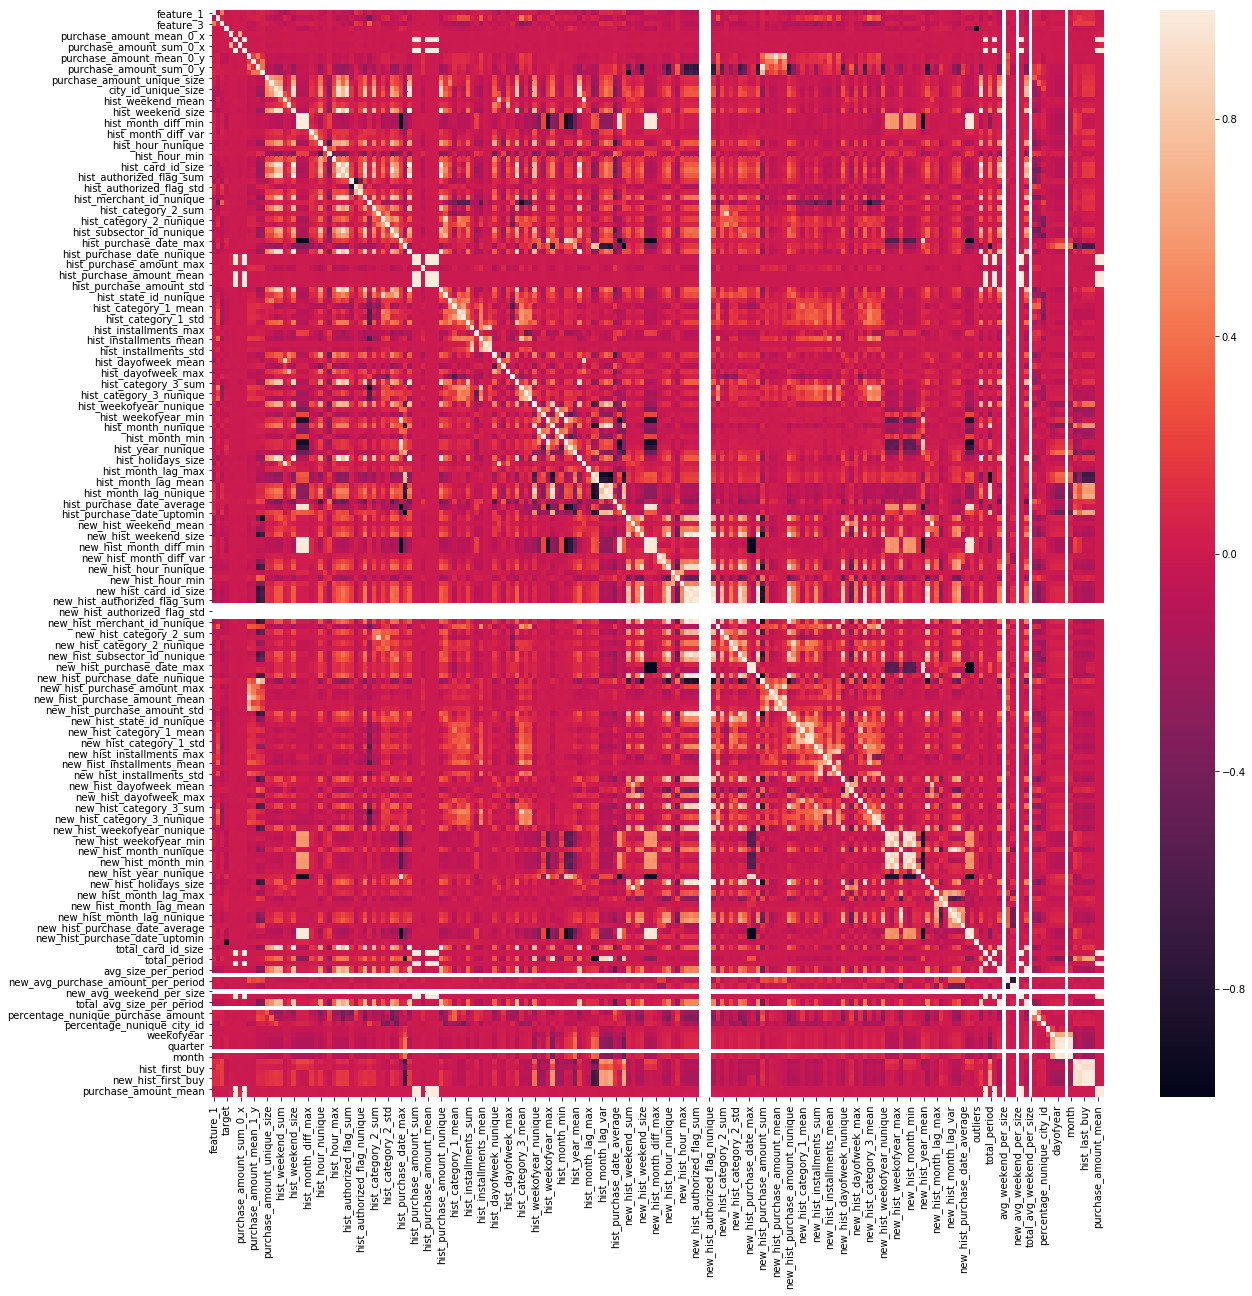

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr())

# 3. Modeling

## 1) Select features

In [25]:
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
print('done')

done


## 2) GridSearchCV and get best parameter

- find best parameters<br/>
- reference : https://www.kaggle.com/gpreda/elo-world-high-score-without-blending

In [33]:
target = train_df['target']
del train_df['target']

In [30]:
from sklearn.model_selection import GridSearchCV, GroupKFold, KFold
#https://github.com/Microsoft/LightGBM/issues/1044

gridParams = {
    'num_leaves': [51],
    'feature_fraction' : [0.90, 0.66],
    'bagging_fraction' : [0.75, 0.90],
    'lambda_l1' : [0.1],
    'min_data_in_leaf' : [45]
    }

gkf = KFold(n_splits=5).split(X=train_df[train_columns],
                                   y=target)
lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt',
                                  objective='regression',
                                  max_depth=-1,
                                  
                                  num_boost_round=50,
                                  bagging_freq=1,
                                  bagging_seed=42,
                                  metric='rmse',
                                  random_state=2019,
                                  learning_rate=0.008,
                                  eval_metric='rmse')

gsearch = GridSearchCV(estimator=lgb_estimator, 
                       param_grid=gridParams, 
                       verbose=1,
                       cv=gkf) 

lgb_model = gsearch.fit(X=train_df[train_columns], 
                        y=target,
                        verbose=1)

print(lgb_model.best_params_, lgb_model.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


{'num_leaves': 51, 'lambda_l1': 0.1, 'min_data_in_leaf': 45, 'bagging_fraction': 0.9, 'feature_fraction': 0.9} 0.04404534135023187


## 3) Model1 - LgihtGBM

In [28]:
'''
#Better then GridCV

param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}
'''

'\n#Better then GridCV\n\nparam = {\'num_leaves\': 51,\n         \'min_data_in_leaf\': 35, \n         \'objective\':\'regression\',\n         \'max_depth\': -1,\n         \'learning_rate\': 0.008,\n         "boosting": "gbdt",\n         "feature_fraction": 0.9,\n         "bagging_freq": 1,\n         "bagging_fraction": 0.9,\n         "bagging_seed": 42,\n         "metric": \'rmse\',\n         "lambda_l1": 0.11,\n         "verbosity": -1,\n         "nthread": 4,\n         "random_state": 2019}\n'

In [ ]:
#model
##model params -Get from gridCV
logger.info('Prepare model')
param = {'num_leaves': 51,
         'min_data_in_leaf': 45, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019
         }

#prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
#run model
logger.info('Start running model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df,train_df['outliers'].values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 500)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    logger.info(strLog)
    
strRMSE = "".format(np.sqrt(mean_squared_error(oof, target)))
print(strRMSE)

##plot the feature importance
logger.info("Feature importance plot")
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances.png')
##submission
logger.info("Prepare submission")
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("final_submission_fold_5_lightgbm.csv", index=False)
print('done')
#sub_df.to_csv("submission.csv", index=False)

[INFO]2020-01-30 18:46:16,111:main:Prepare model
[INFO]2020-01-30 18:46:16,112:main:Start running model


fold 0
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.41687	valid_1's rmse: 3.6715
[1000]	training's rmse: 3.2837	valid_1's rmse: 3.66693
[1500]	training's rmse: 3.1837	valid_1's rmse: 3.66819
Early stopping, best iteration is:
[1102]	training's rmse: 3.26161	valid_1's rmse: 3.66665


[INFO]2020-01-30 18:47:22,394:main:fold 0


fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.42156	valid_1's rmse: 3.66582
[1000]	training's rmse: 3.29333	valid_1's rmse: 3.66103
[1500]	training's rmse: 3.19666	valid_1's rmse: 3.66039
Early stopping, best iteration is:
[1347]	training's rmse: 3.22423	valid_1's rmse: 3.66018


[INFO]2020-01-30 18:48:37,680:main:fold 1


fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.42207	valid_1's rmse: 3.64367
[1000]	training's rmse: 3.28944	valid_1's rmse: 3.63916
Early stopping, best iteration is:
[972]	training's rmse: 3.29592	valid_1's rmse: 3.6391


[INFO]2020-01-30 18:49:39,258:main:fold 2


fold 3
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.40898	valid_1's rmse: 3.68767
[1000]	training's rmse: 3.27382	valid_1's rmse: 3.68471
Early stopping, best iteration is:
[938]	training's rmse: 3.28861	valid_1's rmse: 3.68437


[INFO]2020-01-30 18:50:40,236:main:fold 3


fold 4
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 3.42311	valid_1's rmse: 3.66649
[1000]	training's rmse: 3.2916	valid_1's rmse: 3.65754
[1500]	training's rmse: 3.19311	valid_1's rmse: 3.65628


In [ ]:
exit()

## 4) Model 2 - H2oAutoML
- reference : https://www.kaggle.com/tunguz/elo-with-h2o-automl

In [31]:
train_df['target'] = target

In [ ]:
train_df.to_csv('train_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)
print('done')

In [ ]:
del train_df, test_df; gc.collect()

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init( ip='127.0.0.1',max_mem_size='12G', nthreads = 2)

In [ ]:
train = h2o.import_file('train_df.csv')
test = h2o.import_file('test_df.csv')

In [ ]:
aml = H2OAutoML(max_models=2, seed=47, max_runtime_secs=600)
aml.train(x=train_columns, y='target', training_frame=train)
###Need more than 32GB Ram

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
# The leader model is stored here
aml.leader

In [ ]:
preds = aml.predict(test)

In [ ]:
preds.as_data_frame().values.flatten()
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = preds.as_data_frame().values.flatten()
sample_submission.to_csv('h2o_submission_1.csv', index=False)
print('done')